In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
import nltk

%matplotlib inline

In [3]:
#data set from https://www.kaggle.com/jrobischon/wikipedia-movie-plots/version/1
movie = pd.read_csv("./data/wiki_movie_plots_deduped.csv")
print(movie['Release Year'].max())
print(movie['Release Year'].min())

2017
1901


In [4]:
#34,886 rows of data uncleaned
movie.drop(movie[movie['Genre']=='unknown'].index,inplace=True)
#6,083 rows of the unknown data were dropped
#original data set had over 2,000 unique genres
#had to clean up the Genre column of the data set. Some records had multiple genres listed. Pulled the 1st genre listed ino the Main Genre column. Assumed the 1st listed genre is the primary genre of the film
movie['Genre'] = movie['Genre'].astype('str')
movie['Genre'] = movie['Genre'].str.replace(',','')
movie['Main Genre'] = movie['Genre'].str.split(' ').str[0]
movie['Sub Genre'] = movie['Genre'].str.split(' ').str[0:]
movie.tail(5)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Main Genre,Sub Genre
34877,2013,Particle (film),Turkish,Erdem Tepegöz,"Jale Arıkan, Rüçhan Caliskur, Özay Fecht, Remz...",drama film,https://en.wikipedia.org/wiki/Particle_(film),"Zeynep lost her job at weaving factory, and he...",drama,"[drama, film]"
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the...",comedy,[comedy]
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,"Ata Demirer, Tuvana Türkay, Ülkü Duru",comedy,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i...",comedy,[comedy]
34884,2017,Non-Transferable,Turkish,Brendan Bradley,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romantic comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...,romantic,"[romantic, comedy]"
34885,2017,İstanbul Kırmızısı,Turkish,Ferzan Özpetek,"Halit Ergenç, Tuba Büyüküstün, Mehmet Günsür, ...",romantic,https://en.wikipedia.org/wiki/%C4%B0stanbul_K%...,The writer Orhan Şahin returns to İstanbul aft...,romantic,[romantic]


In [5]:
movie['Main Genre'].value_counts()
#564 types of genre now compared to over 2,000 before

drama                     6818
comedy                    5346
action                    1951
horror                    1379
crime                     1242
                          ... 
historical/drama/triad       1
suhasini                     1
drama/road                   1
muslim                       1
documentary/fiction          1
Name: Main Genre, Length: 564, dtype: int64

In [6]:
#going to pick the top 15 Genres by volume
top15 = list(movie['Main Genre'].value_counts().head(15).index)
movie15 = movie[movie['Main Genre'].isin(top15)]
print(top15)

['drama', 'comedy', 'action', 'horror', 'crime', 'romance', 'thriller', 'western', 'musical', 'romantic', 'adventure', 'science', 'family', 'war', 'animated']


In [8]:
#coded the genres into integer values to fit within the model
movie15['y'] = movie15['Main Genre'].astype('category').cat.codes

C:\Users\Jchap\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


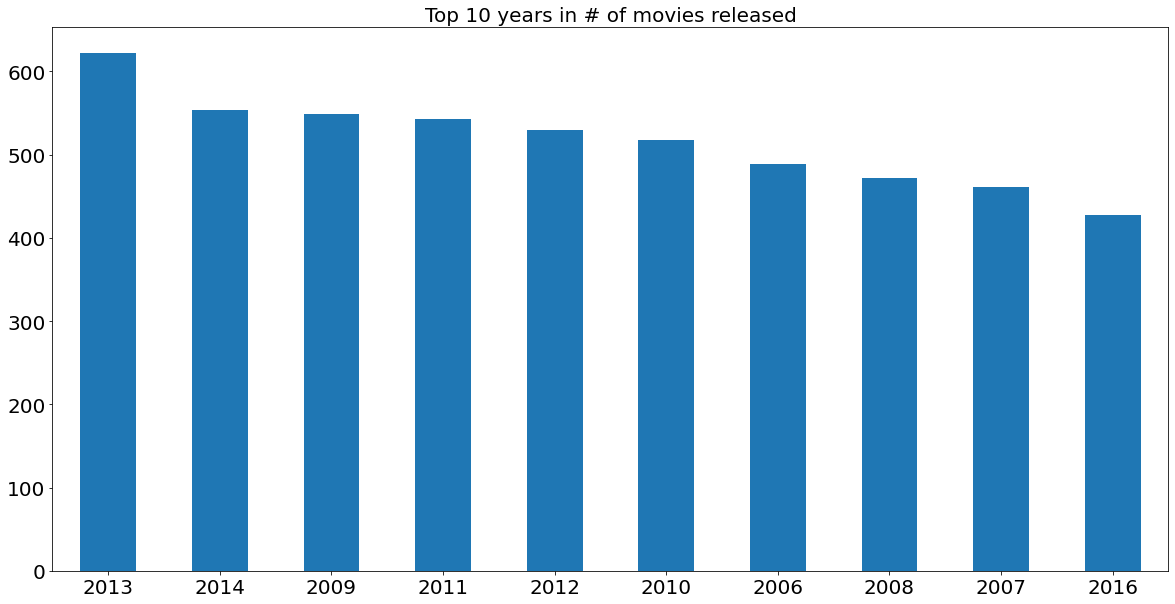

In [92]:
ax = movie15['Release Year'].value_counts().head(10).plot(kind='bar',figsize=(20,10),rot=0);
ax.set_title("Top 10 years in # of movies released",fontsize=20)
ax.tick_params(labelsize=20)

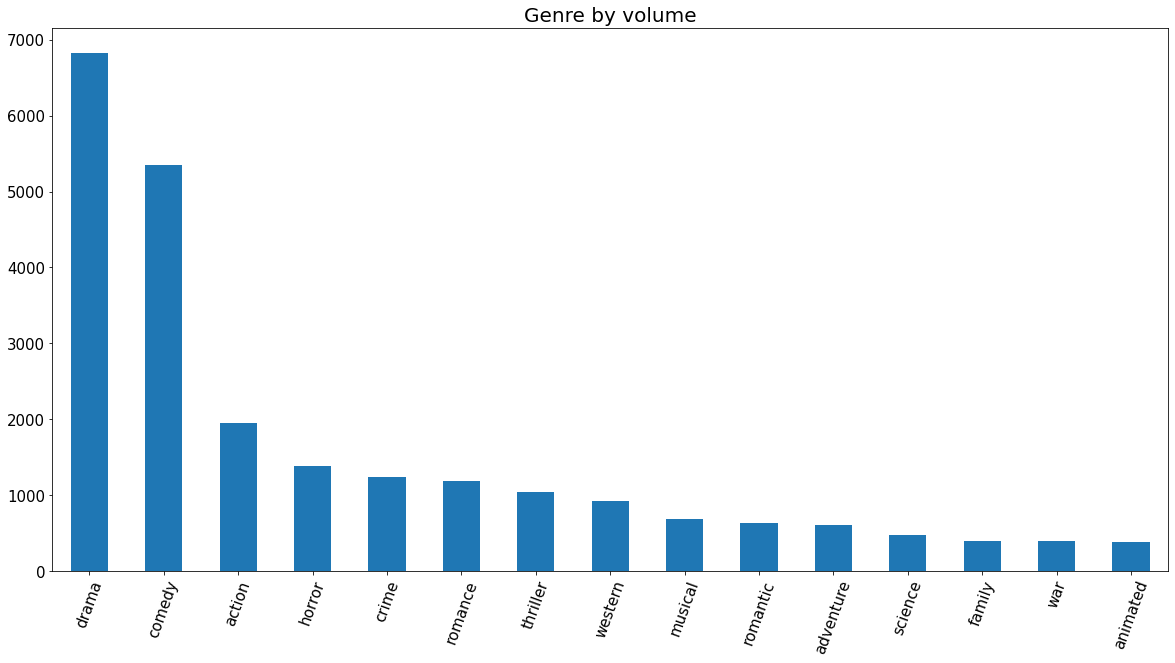

In [99]:
ax = movie15['Main Genre'].value_counts().plot(kind='bar',figsize=(20,10),rot=70);
ax.set_title("Genre by Volume",fontsize=20)
ax.tick_params(labelsize=15)

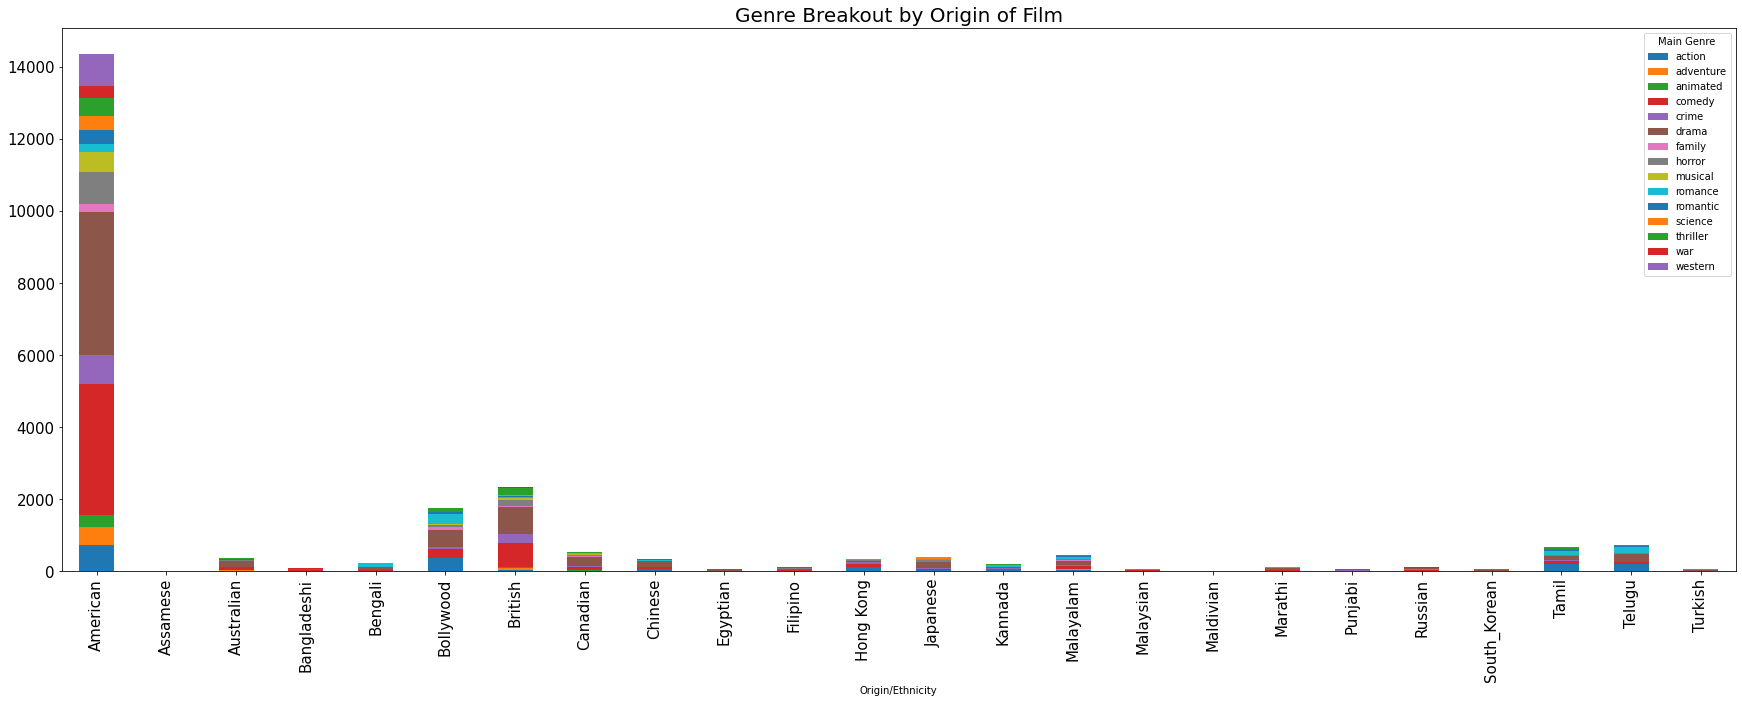

In [58]:
#top comment is normalized version
#used the un-normalized so you could also see the volume of which movies are produced in each country
#origin=movie15.groupby('Origin/Ethnicity')['Main Genre'].value_counts(normalize=True).sort_values(ascending=False).mul(100)
origin=movie15.groupby('Origin/Ethnicity')['Main Genre'].value_counts().sort_values(ascending=False)
ax = origin.unstack().plot.bar(stacked=True,figsize=(30,10))
ax.set_title("Genre Breakout by Origin of Film",fontsize=20)
ax.tick_params(labelsize=15)

In [10]:
#define the independent/dependant variables
X = movie15['Plot']
y = movie15['y']

In [25]:
#create the train and test values
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

# Pipeline

In [69]:
#TFIDF pipeline
tvc_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('mb', MultinomialNB())
])
#Randomforest pipeline
rf_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('rf', RandomForestClassifier())
])
#CountVectorizer pipeline
vc_pipe = Pipeline([
 ('vect', CountVectorizer()),
 ('mb', MultinomialNB())
])
# Fit all three models
tvc_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)
vc_pipe.fit(X_train, y_train)
#Params for TFID
tf_params = {
 'tvec__max_features':[None, 100, 2000, 1000],
 'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
 'tvec__stop_words': [None, 'english'],
 'tvec__min_df':[1, 2, 3]   
 }
#Params for Random Forest
rf_params = {
 'tvec__max_features':[None, 2000],
 'tvec__ngram_range': [(1,1), (1,2), (2,2)],
 'tvec__stop_words': [None, 'english'],
 'rf__max_depth': [100, 1000],
 'rf__min_samples_split': [1, 10, 100],
 'rf__min_samples_leaf': [1, 2 ,3]
}
#Params for Count Vectorizer
vc_params = {
 'vect__max_features':[None, 100, 2000, 1000],
 'vect__ngram_range': [(1, 1), (1, 2), (2,1), (2, 2)],
 'vect__stop_words': [None, 'english'],
 'vect__min_df':[1, 2, 3]   
 }
#method to get parameter keys
#vc_pipe.get_params().keys()

# GridSearch

Running each of these Gridsearches optimizations took hours and made my computer sound like it was about to explode

From what the optimal parameters I could pull from the GridSearch Optimizations I used in the end models

Will leave this section and code in for future use

In [71]:
tvc_gs = GridSearchCV(tvc_pipe, param_grid=tf_params, cv = 5, verbose =1)
tvc_gs.fit(X_train, y_train)
print(tvc_gs.best_score_)
print(tvc_gs.best_params_)

In [ ]:
rf_gs = GridSearchCV(rf_pipe, param_grid=rf_params, cv = 5, verbose = 1)
rf_gs.fit(X_train, y_train)
print(rf_gs.best_score_)
print(rf_gs.best_params_)

In [93]:
vc_gs = GridSearchCV(vc_pipe, param_grid=vc_params, cv = 5, verbose = 1)
vc_gs.fit(X_train, y_train)
print(vc_gs.best_score_)
print(vc_gs.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\Jchap\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jchap\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jchap\anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Jchap\anaconda3\lib\site-packages\sklearn\pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "C:\Users\Jchap\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\Jchap\anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\Jchap\anaconda

C:\Users\Jchap\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jchap\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jchap\anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Jchap\anaconda3\lib\site-packages\sklearn\pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "C:\Users\Jchap\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\Jchap\anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\Jchap\anaconda

KeyboardInterrupt: 

# Models

Ended up going with the countvectorizer with MultinominalNB due to it giving me the highest accuracy out of the three. 

Could've maybe gotten high accruacy from all three if given more time for the gridsearch to run

## TFID with MNB

In [122]:
vc_vect = TfidfVectorizer(min_df=2, ngram_range = (1,1), stop_words='english',token_pattern=r'(?u)\b[A-Za-z]+\b')
vc_X_train = vc_vect.fit_transform(X_train)
vc_X_test = vc_vect.transform(X_test)
print(vc_X_train.shape)
print(vc_X_test.shape)

(17608, 49417)
(5870, 49417)


In [123]:
nb = MultinomialNB()
nb.fit(vc_X_train,y_train)
vc_y_pred_class = nb.predict(vc_X_test)
print(metrics.accuracy_score(y_test,vc_y_pred_class))
#accruacy of 40%

0.3614991482112436


## TFID with RandomForest

In [119]:
rf_vect = TfidfVectorizer(min_df=2, ngram_range = (1,2), stop_words='english',token_pattern=r'(?u)\b[A-Za-z]+\b')
rf_X_train = rf_vect.fit_transform(X_train)
rf_X_test = rf_vect.transform(X_test)
print(rf_X_train.shape)
print(rf_X_test.shape)

(17608, 374810)
(5870, 374810)


In [120]:
clf = RandomForestClassifier(max_features=1000,min_samples_split=2,min_samples_leaf=2,random_state=1)
clf.fit(rf_X_train,y_train)

RandomForestClassifier(max_features=1000, min_samples_leaf=2, random_state=1)

In [121]:
y_clf_predict = clf.predict(rf_X_test)
print(metrics.accuracy_score(y_test,y_clf_predict))
#Accuracy of 42%

0.427427597955707


## CountVectorizer with MNB

In [26]:
vect = CountVectorizer(max_features = 10000, min_df=3,ngram_range=(1,2),stop_words='english',token_pattern=r'(?u)\b[A-Za-z]+\b')
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape)
print(X_test_dtm.shape)


(17608, 10000)
(5870, 10000)


In [131]:
nb = MultinomialNB()
nb.fit(X_train_dtm,y_train)
y_pred_class = nb.predict(X_test_dtm)
print(metrics.accuracy_score(y_test,y_pred_class))
#Accuracy of 52%

0.47189097103918226


In [133]:
#creating dictionary of top words in corpus
DTM = pd.DataFrame(X_train_dtm.toarray(), columns = vect.get_feature_names())
# Create a convenience function that sorts and looks at first n-entries in the dictionary.
def HeadDict(dict_x, n):
# Get items from the dictionary and sort them by
# value key in descending (i.e. reverse) order
    sorted_x = sorted(dict_x.items(),
    reverse = True,
    key = lambda kv: kv[1])
# Convert sorted dictionary to a list.
    dict_x_list = list(sorted_x)
# Return the first `n` values from the dictionary only.
    return(dict(dict_x_list[:n]))
corpus_freq_dist = DTM.sum(axis = 0).to_dict()
print(HeadDict(corpus_freq_dist, 10))


{'s': 85594, 'father': 11762, 'tells': 10466, 'love': 9595, 'man': 9316, 'home': 9294, 'new': 9206, 'time': 8812, 'later': 8803, 'house': 8649}


# Test

Picked my top 5 movies from 2017-2021 to test whether the model could predict the genre correctly

Movie plots for my top 5 were pulled from the Plot section of their corresponding wikipedia page

In [41]:
mytop5 = pd.read_excel("./data/mytop5movies.xlsx")
mytop5.head(5)

,Title,Plot,Main Genre
0,Avengers: Endgame,Twenty-three days after Thanos killed half of ...,action
1,Parasite,"The Kim family—father Ki-taek, mother Chung-so...",drama
2,Spider-Man: Into the Spider-Verse,New York City teenager Miles Morales struggles...,adventure
3,Isle of Dogs,An outbreak of canine influenza spreads throug...,comedy
4,Paddington 2,"Paddington, having settled with the Brown fami...",family


In [134]:
#define new x
fav_x = mytop5['Main Genre']
#transform x to fit into model
fav_x_dtm = vect.transform(fav_x)
#pass new values through model and join values on to df
mytop5['pred'] = nb.predict(fav_x_dtm)

In [135]:
#maps the coded genres back into their original names
mytop5['pred'] = mytop5['pred'].map({5: 'drama', 3: 'comedy'})
mytop5.head()
#model only predicted my top 5 as either drama or comedy
#so 2/5 are right 40% correct. Comparable to the predicted accuracy

,Title,Plot,Main Genre,pred
0,Avengers: Endgame,Twenty-three days after Thanos killed half of ...,action,drama
1,Parasite,"The Kim family—father Ki-taek, mother Chung-so...",drama,drama
2,Spider-Man: Into the Spider-Verse,New York City teenager Miles Morales struggles...,adventure,comedy
3,Isle of Dogs,An outbreak of canine influenza spreads throug...,comedy,comedy
4,Paddington 2,"Paddington, having settled with the Brown fami...",family,drama
